In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
train_df = pd.read_csv("train.csv")
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 数字を「画像として表示」

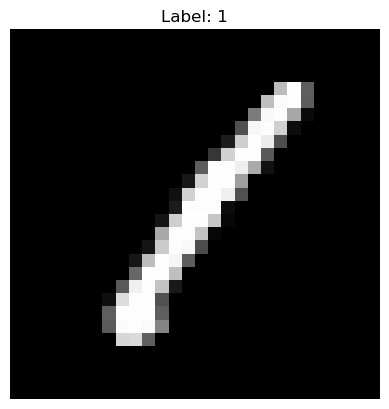

In [14]:
# 1枚取り出す
label = train_df.iloc[0, 0]
pixels = train_df.iloc[0, 1:].values

# 28x28に変形
image = pixels.reshape(28, 28)

plt.imshow(image, cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

### データ分割

In [20]:
X = train_df.iloc[:, 1:]
y = train_df.iloc[:, 0]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

### モデル学習

In [21]:
model = LogisticRegression(max_iter=1000, random_state=0)
model.fit(X_train, y_train)

print("Validation accuracy:", model.score(X_val, y_val))

Validation accuracy: 0.9019047619047619


C:\Users\ND010\anaconda3\envs\torch312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 提出フェーズ

In [22]:
test_df = pd.read_csv("test.csv")

pred = model.predict(test_df)

submission = pd.DataFrame({"ImageId": range(1, len(pred) + 1), "Label": pred})

submission.to_csv("submission.csv", index=False)

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW

#### 設定

In [2]:
# Config
SEED = 42
BATCH_SIZE = 128
EPOCHS = 8
LR = 1e-3
VAL_RATIO = 0.1
NUM_CLASSES = 10

torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


#### データセット

In [3]:
# Dataset (from CSV)
class MNISTFromCSV(Dataset):
    def __init__(self, df: pd.DataFrame, train: bool):
        self.train = train

        if train:
            y = df.iloc[:, 0].values.astype(np.int64)
            x = df.iloc[:, 1:].values.astype(np.float32)
            self.y = torch.tensor(y, dtype=torch.long)
        else:
            x = df.values.astype(np.float32)
            self.y = None

        # [N, 784] -> [N, 1, 28, 28]
        x = x.reshape(-1, 1, 28, 28)

        # 0-255 -> 0-1
        x = x / 255.0

        # MNISTの定番正規化（学習が安定）
        # mean=0.1307, std=0.3081 はよく使われる
        x = (x - 0.1307) / 0.3081

        self.x = torch.tensor(x, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if self.train:
            return self.x[idx], self.y[idx]
        return self.x[idx]

#### モデル構築

In [4]:
# ----------------------------
# Model (Simple CNN)
# ----------------------------
# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes=10):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # 28x28
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 28x28
#         self.pool = nn.MaxPool2d(2, 2)                            # -> 14x14
#         self.dropout = nn.Dropout(0.25)
#         self.fc1 = nn.Linear(64 * 14 * 14, 128)
#         self.fc2 = nn.Linear(128, num_classes)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)
#         x = self.dropout(x)
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x
class BetterCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7
        )
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

#### 学習・評価の関数

In [5]:
# Train / Eval
def accuracy(logits, y):
    pred = logits.argmax(dim=1)
    return (pred == y).float().mean().item()


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_acc += accuracy(logits.detach(), y) * x.size(0)

    n = len(loader.dataset)
    return total_loss / n, total_acc / n


@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_acc = 0.0, 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        total_acc += accuracy(logits, y) * x.size(0)

    n = len(loader.dataset)
    return total_loss / n, total_acc / n


@torch.no_grad()
def predict(model, loader):
    model.eval()
    preds = []
    for x in loader:
        x = x.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1).cpu().numpy()
        preds.append(pred)
    return np.concatenate(preds)

#### データロード

In [6]:
# Load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

full_ds = MNISTFromCSV(train_df, train=True)
val_size = int(len(full_ds) * VAL_RATIO)
train_size = len(full_ds) - val_size
train_ds, val_ds = random_split(
    full_ds, [train_size, val_size], generator=torch.Generator().manual_seed(SEED)
)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True
)

test_ds = MNISTFromCSV(test_df, train=False)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True
)

#### 実行

In [7]:
# Run
model = BetterCNN(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR)

best_val_acc = 0.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, va_acc = eval_one_epoch(model, val_loader, criterion)

    print(
        f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}"
    )

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

print("Best val acc:", best_val_acc)

# ベストをロード
model.load_state_dict(best_state)

Epoch 01 | train loss 0.1908 acc 0.9404 | val loss 0.0550 acc 0.9848
Epoch 02 | train loss 0.0572 acc 0.9824 | val loss 0.0566 acc 0.9831
Epoch 03 | train loss 0.0424 acc 0.9870 | val loss 0.0494 acc 0.9862
Epoch 04 | train loss 0.0371 acc 0.9879 | val loss 0.0466 acc 0.9862
Epoch 05 | train loss 0.0321 acc 0.9899 | val loss 0.0522 acc 0.9876
Epoch 06 | train loss 0.0283 acc 0.9911 | val loss 0.0398 acc 0.9890
Epoch 07 | train loss 0.0235 acc 0.9928 | val loss 0.0375 acc 0.9905
Epoch 08 | train loss 0.0231 acc 0.9926 | val loss 0.0505 acc 0.9864
Best val acc: 0.9904761904761905


<All keys matched successfully>

In [8]:
model.to(device)
model.eval()

# 予測用に state_dict を保存
torch.save(model.state_dict(), "mnist_cnn.pt")

print("saved:", "mnist_cnn.pt")

saved: mnist_cnn.pt


In [4]:
# ----------------------------
# Submit
# ----------------------------
test_pred = predict(model, test_loader)

submission = pd.DataFrame(
    {"ImageId": np.arange(1, len(test_pred) + 1), "Label": test_pred}
)
submission.to_csv("submission5.csv", index=False)
print("saved: submission.csv")

saved: submission.csv


device: cpu  
Epoch 01 | train loss 0.1908 acc 0.9404 | val loss 0.0550 acc 0.9848  
Epoch 02 | train loss 0.0572 acc 0.9824 | val loss 0.0566 acc 0.9831  
Epoch 03 | train loss 0.0424 acc 0.9870 | val loss 0.0494 acc 0.9862  
Epoch 04 | train loss 0.0371 acc 0.9879 | val loss 0.0466 acc 0.9862  
Epoch 05 | train loss 0.0321 acc 0.9899 | val loss 0.0522 acc 0.9876  
Epoch 06 | train loss 0.0283 acc 0.9911 | val loss 0.0398 acc 0.9890  
Epoch 07 | train loss 0.0235 acc 0.9928 | val loss 0.0375 acc 0.9905  
Epoch 08 | train loss 0.0231 acc 0.9926 | val loss 0.0505 acc 0.9864  
Best val acc: 0.9904761904761905